In [1]:
import os
from segment_anything.build_sam import sam_model_registry
from scripts.experiments.mask_aug.inference import class_inference, load_model
from scripts.sam_train import SamTrain
from segment_anything.modeling.sam import Sam
VAL_ROOT = "../dataset/FLARE22-version1/ReleaseValGT-20cases"
VOLUME_CACHE = os.path.join(VAL_ROOT, "images/FLARETs_0002_0000.cache.pt")
IMAGE_PATH = os.path.join(VAL_ROOT, "images/FLARETs_0002_0000.nii.gz")
MASK_PATH = os.path.join(VAL_ROOT, "labels/FLARETs_0002.nii.gz")
MODEL_PATH = "../runs/transfer/imp-230603-150046/model-20.pt"

model: Sam = sam_model_registry["vit_b"](
        checkpoint="../sam_vit_b_01ec64.pth", custom=MODEL_PATH
    )
sam_train = SamTrain(sam_model=model)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scripts.datasets.constant import IMAGE_TYPE
from scripts.datasets.preprocess_raw import FLARE22_Preprocess
from scripts.utils import torch_try_load

%matplotlib inline


preprocessor = FLARE22_Preprocess()
volumes, masks = preprocessor.run_with_config(
            image_file=IMAGE_PATH,
            gt_file=MASK_PATH,
            config_name=IMAGE_TYPE.ABDOMEN_SOFT_TISSUES_ABDOMEN_LIVER,
        )
cache_volume = torch_try_load(VOLUME_CACHE, 'cpu')


In [3]:
from scripts.experiments.mask_aug.inference import get_all_organ_range


starts, ends = get_all_organ_range(masks)

In [ ]:
starts, ends

In [4]:
from time import time_ns
from typing import Dict

from scripts.datasets.f22_improve import Augmentation
from scripts.experiments.mask_aug.inference import pick_best_mask
import torch
from scipy.ndimage import gaussian_filter

aug_fn = Augmentation({})

def pick_one_pixel(mask: torch.Tensor, radius=3, seed=10, gaussian_config=None):
    # binary mask input
    coors = torch.argwhere(mask)
    idx = np.random.RandomState(seed=seed).randint(low=0, high=coors.shape[0])
    x = coors[idx][0].item()
    y = coors[idx][1].item()
    result = np.zeros(mask.shape)
    xmax = min(x + radius, mask.shape[0])
    ymax = min(y + radius, mask.shape[1])
    xmin = max(x - radius, 0)
    ymin = max(y - radius, 0)
    result[xmin:xmax, ymin:ymax] = 1.0

    if gaussian_config:
        result = gaussian_filter(result, sigma=gaussian_config['sigma'])
        result = (result - np.min(result)) / (np.max(result) - np.min(result))
    
    result = torch.as_tensor(result)
    return result

@torch.no_grad()
def inference(
        volumes: np.ndarray, 
        masks: np.ndarray, 
        caches: np.ndarray, 
        idx: int, 
        target_idx: int,
        radius:int,
        seed:int,
        gaussian_config:Dict[str, object]=None,
    ):
    original_size = caches[idx]['original_size']
    input_size = caches[idx]['input_size']
    img_emb = caches[idx]['img_emb']
    
    previous_mask = torch.as_tensor(masks[idx - 1].copy() == target_idx)
    # previous_mask = aug_fn.one_block_drop(previous_mask, max_crop_ratio=0.9, augmentation_prop=1.0)
    previous_mask = pick_one_pixel(previous_mask, radius=radius, seed=seed, gaussian_config=gaussian_config)
    
    start = time_ns()
    _, _, _, mask_input_torch = sam_train.prepare_prompt(
        original_size=original_size, mask_input=previous_mask[None, ...]
    )

    mask_logits, _, low_res_mask = sam_train.predict_torch(
        image_emb=img_emb,  # 1, 256, 64, 64
        input_size=input_size,
        original_size=original_size,
        multimask_output=True,
        # Get the logit to compute the stability
        return_logits=True,
        mask_input=mask_input_torch,
    )

    mask_pred = mask_logits > 0.0
    
    chosen_idx, _ = pick_best_mask(
        pred_multi_mask=mask_pred,
        previous_mask=previous_mask,
        gt_binary_mask=None,
        device='cpu',
        strategy='prev'
    )
    stop = time_ns()
    duration = stop - start
    return chosen_idx, mask_pred, low_res_mask, mask_logits, duration, previous_mask


chosen_idx, mask_pred, low_res_mask, mask_logits, duration, previous_mask = inference(
    volumes=volumes,
    masks=masks,
    caches=cache_volume,
    idx=120,
    target_idx=1,
    radius=20,
    seed=10,
    gaussian_config=None
)



In [27]:
import copy




array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

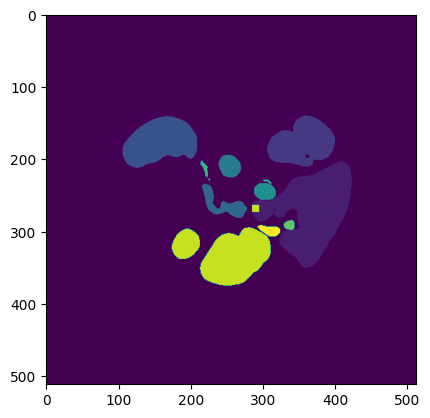

In [45]:
idx = 130
result = aug_fn.pick_square(
    mask=torch.as_tensor((masks[idx] == 1).astype(np.uint8), dtype=torch.uint8).clone(),
    radius=5
)
# f, ax = plt.subplots(1, 2)
# ax[0].imshow(result.numpy())
# ax[1].imshow(masks[130] == 1)
plt.imshow(result.numpy()*10 + masks[idx])

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

idx = 134
previous_mask = masks[idx - 1].copy() == 1
target_mask = masks[idx].copy() == 1
img = volumes[idx]

chosen_idx, mask_pred, low_res_mask, mask_logits, duration, previous_mask = inference(
    volumes=volumes,
    masks=masks,
    caches=cache_volume,
    idx=idx,
    target_idx=1,
    radius=10,
    seed=(time_ns() & (2**32 - 1)),
    gaussian_config={'sigma': 30}
)

f, axes = plt.subplots(2, 3)
axes[0, 0].imshow(mask_pred[0, chosen_idx])
axes[0, 1].imshow(target_mask)
axes[0, 2].imshow(low_res_mask[0, chosen_idx].numpy())

axes[1, 0].imshow(previous_mask)
axes[1, 1].imshow(img)
axes[1, 2].imshow(mask_logits[0, chosen_idx].numpy())

axes[0, 0].set_title('Pred')
axes[0, 1].set_title('Target')
axes[1, 0].set_title('Previous')
axes[1, 1].set_title('Image')
# plt.colorbar()


In [ ]:
from segment_anything.utils.amg import calculate_stability_score
r = []
for value in range(-20, 20, 1):
    result = calculate_stability_score(masks=mask_logits[0, chosen_idx], mask_threshold=value / 2.0, threshold_offset=1.0)
    r.append((value / 2.0, result))

print(r)
print(max(r, key=lambda x: x[1]))

In [ ]:
f, axes = plt.subplots(2, 3)
axes[0, 0].imshow(mask_logits[0, chosen_idx].numpy() > -10.)
axes[0, 1].imshow(target_mask)
axes[0, 2].imshow(low_res_mask[0, chosen_idx].numpy())

axes[1, 0].imshow(previous_mask)
axes[1, 1].imshow(img)
axes[1, 2].imshow(mask_logits[0, chosen_idx].numpy() - 0.5)

axes[0, 0].set_title('Pred')
axes[0, 1].set_title('Target')
axes[1, 0].set_title('Previous')
axes[1, 1].set_title('Image')
# plt.colorbar()

In [ ]:
def norm_minmax(inp):
    return (inp - np.min(inp)) / (np.max(inp) - np.min(inp))


def evolution(
        masks: np.ndarray, 
        caches: np.ndarray, 
        idx: int, 
        target_idx: int,
        start_radius: int,
        gaussian_config: Dict[str, object],
        n_round: int,
        seed: int,
    ):
    original_size = caches[idx]['original_size']
    input_size = caches[idx]['input_size']
    img_emb = caches[idx]['img_emb']

    dices = []
    result = []
    
    previous_mask = torch.as_tensor(masks[idx - 1].copy() == target_idx)
    previous_mask = pick_one_pixel(previous_mask, radius=start_radius, gaussian_config=gaussian_config, seed=seed)
    init_mask = previous_mask.clone()

    for _ in range(n_round):
        _, _, _, mask_input_torch = sam_train.prepare_prompt(
            original_size=original_size, mask_input=previous_mask[None, ...]
        )

        mask_logits, _, _ = sam_train.predict_torch(
            image_emb=img_emb,  # 1, 256, 64, 64
            input_size=input_size,
            original_size=original_size,
            multimask_output=True,
            # Get the logit to compute the stability
            return_logits=True,
            mask_input=mask_input_torch,
        )

        mask_pred = mask_logits > 0.0
        
        chosen_idx, dice_score = pick_best_mask(
            pred_multi_mask=mask_pred,
            previous_mask=previous_mask,
            gt_binary_mask=None,
            device='cpu',
            strategy='prev'
        )
        dices.append(dice_score)
        previous_mask = mask_pred[0, chosen_idx].numpy()
        if gaussian_config is not None:
            if gaussian_config.get('prev_sigma') is not None:
                previous_mask = gaussian_filter(previous_mask.astype(np.float32), sigma=gaussian_config['prev_sigma'])
                previous_mask = norm_minmax(previous_mask)
        result.append(previous_mask.copy())
        pass
    
    return chosen_idx, mask_pred, result, init_mask, dices

idx = 130
chosen_idx, mask_pred, result, init_mask, dices = evolution(
    masks=masks,
    caches=cache_volume,
    idx=idx,
    target_idx=1,
    start_radius=4,
    n_round=10,
    gaussian_config={
        'sigma': 10.0,
        'prev_sigma': 3.5,
    },
    # seed=(time_ns() & (2**32 - 1)),
    seed=10,
)

target_mask = masks[idx].copy() == 1
img = volumes[idx]

f, axes = plt.subplots(2, 2)
axes[0, 0].imshow(mask_pred[0, chosen_idx])
axes[0, 1].imshow(target_mask)
axes[1, 0].imshow(init_mask)
axes[1, 1].imshow(img)

axes[0, 0].set_title('Pred')
axes[0, 1].set_title('Target')
axes[1, 0].set_title('Init mask')
axes[1, 1].set_title('Image')

print(dices)

f, axes = plt.subplots(3, 4)
for i1 in range(3):
    for i2 in range(4):
        if i1 * 4 + i2 >= len(result): break
        axes[i1, i2].imshow(result[i1 * 4 + i2])
        pass

In [ ]:
from torch import Tensor

def expansion_metric(a1: Tensor, a2: Tensor):
    if not isinstance(a1, Tensor):
        a1 = Tensor(a1)
    if not isinstance(a2, Tensor):
        a2 = Tensor(a2)
    intersection = (a1 * a2).sum()
    # Check the intersection coverage compare to the max
    expansion_ratio = torch.max(a1.sum(), a2.sum()) / intersection
    coverage_ratio = intersection / torch.min(a1.sum(), a2.sum())
    return expansion_ratio, coverage_ratio

expansion_ratio, coverage_ratio = expansion_metric(result[0] > 0.0, result[-1] > 0.0)
print(
    expansion_ratio,
    coverage_ratio
)

In [ ]:
def gkern(l=5, sig=1.):
    """\
    creates gaussian kernel with side length `l` and a sigma of `sig`
    """
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

def create_gaussian_2d_kernel(length: int, sigma: float):
    """\
    creates gaussian kernel with side length `l` and a sigma of `sig`
    """
    ax = torch.linspace(-(length - 1) / 2.0, (length - 1) / 2.0, length)
    gauss = torch.exp(-0.5 * torch.square(ax) / torch.square(torch.as_tensor(sigma)))
    kernel = torch.outer(gauss, gauss)
    return kernel / torch.sum(kernel)

gkern() - create_gaussian_2d_kernel(5, 1.).numpy()

In [ ]:
from typing import Callable, List, Optional
import uuid

class BeamSearchInferenceEngine:
    def __init__(
            self, 
            volumes: Tensor, 
            caches: Tensor, 
            masks: Tensor, 
            stability_config: Dict[str, object]
            ) -> None:
        self.volumes = volumes
        self.caches = caches
        self.masks = masks
        
        self.stability_config = self.prepare_default_stability_config(stability_config)
        self.starts, self.ends = get_all_organ_range(masks)
        
        pass
    

    def prepare_default_stability_config(self, stability_config: Dict[str, object]):
        stability_config = stability_config or {}
        stability_config['threshold_start'] = stability_config.get('threshold_start', 0.1)
        stability_config['threshold_end'] = stability_config.get('threshold_end', 0.9)
        stability_config['threshold_num'] = stability_config.get('threshold_num', 10)
        stability_config['offset'] = stability_config.get('offset', 0.1)
        return stability_config
    
    @torch.no_grad()
    def core_inference(self, idx: int, previous_mask: Tensor):
        original_size = self.caches[idx]['original_size']
        input_size = self.caches[idx]['input_size']
        img_emb = self.caches[idx]['img_emb']

        _, _, _, mask_input_torch = sam_train.prepare_prompt(
            original_size=original_size, mask_input=previous_mask[None, ...]
            )

        mask_logits, _, _ = sam_train.predict_torch(
            image_emb=img_emb,  # 1, 256, 64, 64
            input_size=input_size,
            original_size=original_size,
            multimask_output=True,
            # Get the logits to compute the stability
            return_logits=True,
            mask_input=mask_input_torch,
        )

        mask_pred = mask_logits > 0.0
        
        chosen_idx, _ = pick_best_mask(
            pred_multi_mask=mask_pred,
            previous_mask=previous_mask,
            gt_binary_mask=None,
            device='cpu',
            strategy='prev'
        )
        
        return chosen_idx, mask_logits
    
    def calculate_stability_score_with_sigmoid(
        self, masks: torch.Tensor, mask_threshold: float, threshold_offset: float
    ) -> torch.Tensor:
        """
        Exactly like the `calculate_stability_score`, but using sigmoid for better scale
        """
        # One mask is always contained inside the other.
        # Save memory by preventing unnecessary cast to torch.int64
        sigmoid_masks = torch.sigmoid(masks)
        intersections = (
            (sigmoid_masks > (mask_threshold + threshold_offset))
            .sum(-1, dtype=torch.int16)
            .sum(-1, dtype=torch.int32)
        )
        unions = (
            (sigmoid_masks > (mask_threshold - threshold_offset))
            .sum(-1, dtype=torch.int16)
            .sum(-1, dtype=torch.int32)
        )
        return intersections / unions
    
    def generate_option(self, mask_logits, chosen_idx, prev_id):
        options = []
        start = self.stability_config['threshold_start']
        end = self.stability_config['threshold_end']
        num = self.stability_config['threshold_num']
        for value in np.linspace(start=start, stop=end, num=num):
            score = self.calculate_stability_score_with_sigmoid(
                masks=mask_logits[0, chosen_idx],
                mask_threshold=value, 
                threshold_offset=self.stability_config['offset']
                )
            options.append([value, score, uuid.uuid4(), prev_id, mask_logits[0, chosen_idx]])
        return options

    def ranking_fn(self, options, score):
        for option in options:
            score  = score + np.log(option[1] + 1e-30)
            option[1] = score
            pass
        
        return sorted(options, key=lambda x: x[1], reverse=True)
        
    def beam_search_inference(
            self, 
            start_idx: int, 
            end_idx: int,
            target_idx: int, 
            start_radius: float, 
            gaussian_config: Dict[str, object], 
            seed: Optional[int] = None, 
            beam_width: int = 3,
        ):
        if seed is None:
            seed = time_ns() % (2**32 - 1)
        
        init_mask = torch.as_tensor(self.masks[start_idx - 1].copy() == target_idx)
        init_mask = pick_one_pixel(init_mask, radius=start_radius, gaussian_config=gaussian_config, seed=seed)
        score = 0.0
        options = [[0.0, 1.0, uuid.uuid4(), None, init_mask]]
        tracing = []
        for idx in range(start_idx, end_idx):
            buffer = []
            for option in options:
                previous_mask = option[-1] > option[0] if option[-2] is not None else option[-1]
                chosen_idx, mask_logits = self.core_inference(
                    idx=idx, previous_mask=previous_mask
                )
                new_options = self.generate_option(mask_logits, chosen_idx, prev_id=option[2])
                buffer.extend(new_options)
                pass
            options = self.ranking_fn(buffer, score)[:beam_width]
            tracing.append(options)
            pass
        
        return tracing, init_mask
    
    def retrace(self, tracing: List[object]):
        result = []
        best_option = max(tracing[-1], key=lambda x: x[1])
        [value, score, current_id, prev_id, mask_logits] = best_option
        pred = mask_logits > value
        result.append(pred)
        # reverse, skip the last option
        for trace in tracing[-2::-1]:
            best_option = next(filter(lambda x: x[2] == prev_id, trace))
            [value, _, current_id, prev_id, mask_logits] = best_option
            pred = mask_logits > value
            result.append(pred)
            pass
        # reverse the tracing again
        return result[::-1]

In [ ]:
engine = BeamSearchInferenceEngine(volumes=volumes, caches=cache_volume, masks=masks, stability_config=None)
tracing, init_mask = engine.beam_search_inference(
    start_idx=130,
    end_idx=140,
    target_idx=1,
    start_radius=3,
    gaussian_config={'sigma': 10.0},
    beam_width=3,
    seed=10
)
data = engine.retrace(tracing)

In [ ]:
idx = 135
target_mask = masks[idx].copy() == 1
img = volumes[idx]
f, axes = plt.subplots(2, 2)
axes[0, 0].imshow(data[idx - 130])
axes[0, 1].imshow(target_mask)
axes[1, 0].imshow(init_mask)
axes[1, 1].imshow(img)

axes[0, 0].set_title('Pred')
axes[0, 1].set_title('Target')
axes[1, 0].set_title('Init mask')
axes[1, 1].set_title('Image')

In [ ]:
aug = Augmentation(aug_config=None, seed=10)